In [1]:
import scipy.io as sci
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# 文件载入
# fileDrive = r'C:\Users\mikel\Desktop\Guosheng\Daily'
fileDrive = r'C:\Users\mikel\Desktop\Guosheng\Daily'
openPriceF = sci.loadmat(fileDrive+'\AllStock_DailyOpen_dividend.mat')
closePriceF = sci.loadmat(fileDrive+'\AllStock_DailyClose_dividend.mat')
listedDaysF = sci.loadmat(fileDrive+'\AllStock_DailyListedDate.mat')
stF = sci.loadmat(fileDrive+'\AllStock_DailyST.mat')
dailyStatusF = sci.loadmat(fileDrive+'\AllStock_DailyStatus.mat')
turnOverF = sci.loadmat(fileDrive+'\AllStock_DailyTR.mat')
tradingDateF = sci.loadmat(r'C:\Users\mikel\Desktop\Guosheng\Daily\TradingDate_Daily.mat')
stockCodeF = sci.loadmat(r'C:\Users\mikel\Desktop\Guosheng\Daily\AllStockCode.mat')
zz500 = pd.read_excel(fileDrive + '\指数成分股 300&500.xlsx',sheet_name='中证500',header = 0)
# 导入文件中的数据到np array
openPrice = openPriceF['AllStock_DailyOpen_dividend']
closePrice = closePriceF['AllStock_DailyClose_dividend']
listedDays = listedDaysF['AllStock_DailyListedDate']
stStatus = stF['AllStock_DailyST']
dailyStatus = dailyStatusF['AllStock_DailyStatus_use']
turnOver = turnOverF['AllStock_DailyTR']
tradingDate = tradingDateF['TradingDate_Daily']
stockCode =  stockCodeF['AllStockCode']

In [3]:
# 样本大小
stocks = openPrice.shape[1]   # 4952 stocks
days = openPrice.shape[0]   #4452 days
startDay = 2240   # 2013/3/27
endDay = 3407    # 3406 is 2018/1/5
validDays = endDay - startDay  #1167 days

In [4]:
#储存数据年月信息
yearDigit = np.zeros(validDays)
monthDigit = np.zeros(validDays)
for i in range(startDay,endDay):
    yearDigit[i - startDay] = tradingDate[i]//10000
    monthDigit[i - startDay] = tradingDate[i]//100%100

In [5]:
#储存中证500年月信息
numMonth = zz500.shape[1]
zz500Year = np.zeros([numMonth])
zz500Month = np.zeros([numMonth])
for i in range (numMonth):
    timeStr = zz500.columns[i].strftime('%Y-%m-%d %H:%M:%S')
    yearStr = timeStr[:4]
    zz500Year[i] = int(yearStr)
    monthStr = timeStr[5:7]
    zz500Month[i] = int(monthStr)

In [6]:
# 挑出要选的样本,用表isValid作标记
isValid = np.zeros((validDays,stocks))
for i in range(startDay,endDay):
    for j in range(stocks):
        if listedDays[i][j] > 60 and stStatus[i][j] == 0 and dailyStatus[i-1][j] == 1 and dailyStatus[i][j] == 1 and openPrice[i][j] < closePrice[i-1][j] and openPrice[i][j]/closePrice[i-1][j] - 1 > -0.098:
            isValid[i-startDay][j] = 1
        else: 
            isValid[i-startDay][j] = 0

In [7]:
#尋找列數
def find_col(x):
    yearDigit = tradingDate[x]//10000
    monthDigit = tradingDate[x]//100%100
    col_index = (yearDigit - 2007)*12 + monthDigit - 1
    return col_index

In [8]:
#是否为中证500成分股
isZz500 = np.zeros((validDays,stocks))
for j in range(validDays):
    for k in range(stocks):
        i = find_col(validDays + startDay)
        if stockCode[0][k][0] in zz500.iloc[:,i].values:
                isZz500[j][k] = 1

In [9]:
# 辅助函数，用于计算值X在数组V中的排序位置
def percentile_rank(x,v):
    return (v <= x).sum() / len(v)

In [10]:
# 辅助函数，计算Q
def calculateQ(stock,dayIndex):
    turnoverArray = np.zeros(60)
    for i in range(dayIndex - 60, dayIndex):
        turnoverArray[i - dayIndex + 60] = turnOver[i][stock]
    return percentile_rank(turnOver[dayIndex-1][stock],turnoverArray)

In [11]:
# 计算换手率，归入相应组别,存于表turnOverQ中
turnOverQ = np.zeros((validDays,stocks))
for i in range(startDay,endDay):
    sampleList = []
    for j in range(stocks):
        if isValid[i-startDay][j] == 1 and isZz500[i-startDay][j] == 1:
            sampleList.append(calculateQ(j,i))
    sampleArray = np.array(sampleList)
    for j in range(stocks):
        if isValid[i-startDay][j] == 1 and isZz500[i-startDay][j] == 1:
            percentile = percentile_rank(calculateQ(j,i),sampleArray)
            if percentile != 1:
                turnOverQ[i - startDay][j] = percentile * 100 // 20 + 1
            else:
                turnOverQ[i - startDay][j] = 5

In [12]:
turnOverQ

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
# 计算所选样本当日回报率
returnArray = np.zeros((5,validDays))   # 记录每一天每个组别回报率累计
counter = np.zeros((5,validDays))     # 记录每一天每个组别样本数
lowPriceF = sci.loadmat(fileDrive+'\AllStock_DailyLow_dividend.mat')
lowPrice = lowPriceF['AllStock_DailyLow_dividend']
for i in range(startDay,endDay): 
    for j in range(stocks):
        if isValid[i - startDay][j] == 1 and isZz500[i-startDay][j] == 1:
            if lowPrice[i][j]/closePrice[i-1][j] - 1 < -0.098:
                returnRate = lowPrice[i][j]/openPrice[i][j] - 1
            else:
                returnRate = closePrice[i][j]/openPrice[i][j] - 1
            returnArray[int(turnOverQ[i - startDay][j]) - 1][i - startDay] = returnArray[int(turnOverQ[i - startDay][j]) - 1][i- startDay] + returnRate
            counter[int(turnOverQ[i - startDay][j]) - 1][i - startDay] = counter[int(turnOverQ[i - startDay][j]) - 1][i - startDay] + 1

dailyAverageReturn = np.zeros([5,validDays])
for i in range(5):
    for j in range (validDays):
        if counter[i][j] != 0:
            dailyAverageReturn[i][j] = returnArray[i][j] / counter[i][j]

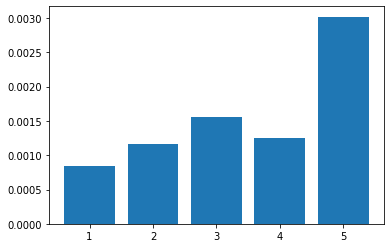

In [14]:
averageReturn = np.average(dailyAverageReturn, axis=1) 
plt.bar(range(1,len(averageReturn)+1), averageReturn)
plt.show()